# Assignment 2

In the last few lectures, you have looked at two work-horses of natural language processing: recurrent neural networks, and word embeddings (distributional semantics). In this assignment, you will put the learning into practice by implementing some of these yourself, and doing some exploratory analysis.

# Setup

For this assignment, as in the previous one, we will be using Google Colab, for both code as well as descriptive questions. Your task is to finish all the questions in the Colab notebook and then upload a PDF version of the notebook, and a viewable link on Gradescope. 

### Google colaboratory

Before getting started, get familiar with google colaboratory:
https://colab.research.google.com/notebooks/welcome.ipynb

This is a neat python environment that works in the cloud and does not require you to
set up anything on your personal machine
(it also has some built-in IDE features that make writing code easier).
Moreover, it allows you to copy any existing collaboratory file, alter it and share
with other people.

### Submission

Before you start working on this homework do the following steps:

1. Press __File > Save a copy in Drive...__ tab. This will allow you to have your own copy and change it.
2. Follow all the steps in this collaboratory file and write / change / uncomment code as necessary.
3. Do not forget to occasionally press __File > Save__ tab to save your progress.
4. After all the changes are done and progress is saved press __Share__ button (top right corner of the page), press __get shareable link__ and make sure you have the option __Anyone with the link can view__ selected.
5. After completing the notebook, press __File > Download .ipynb__ to download a local copy on your computer, and then use `jupyter nbconvert --to pdf intro-hlt-hw2.ipynb` to convert the notebook into PDF format for uploading on Gradescope.

```
# Paste your Colab notebook link here
https://colab.research.google.com/drive/1JJoZYwO8ExF0PGV8dtzkF3JK6dsNZUTk?usp=sharing
```



### Part 1: Language modeling with RNNs

For the first part of this assignment, you will train a character-level language model on a lyrics dataset.

More specifically, you will:
1. Implement a character-level language model based on recurrent neural networks.
2. Train it on a lyrics dataset.
3. Sample previously unseen lyrics from our model.
4. Augment your model with an artist information, so that you can generate songs conditioned on some artist.

Let's get started!

#### Character-Level language model

![alt text](http://warmspringwinds.github.io/assets/img/character_level_model.jpg "Logo Title Text 1")

Before choosing a model, let’s have a closer look at our task. Given current letter and all previous letters, we will try to predict the next character. During training we will just take a sequence, and use all its characters except the last one as an input and the same sequence starting from the second character as groundtruth (see the picture above).

Our language model is defined on a character level. We will create a dictionary which will contain all English characters plus some special symbols, such as period, comma, and end-of-line symbol. Each charecter will be represented as one-hot-encoded tensor. For more information about character-level models and examples, refer to the [the following resource](https://github.com/spro/practical-pytorch).


Our objective is to model is _p_(current letter | all previous letters). At first, the task seems intractable as the number of previous letters is variable and it might become really large in case of long sequences. 

__Question:__ Based on what you learned in Assignment 1, describe how you would deal with this problem? _(2 points)_

__Answer:__ We can use the n-gram model to specify the number of previous letters. So large scale sequences could be the same as tiny senquences.

#### Recurrent Neural Networks (RNNs)

![alt text](http://warmspringwinds.github.io/assets/img/rnn_unfold.jpg "Logo Title Text 1")

RNNs are a family of neural networks for processing sequential data. Unlike feedforward neural networks, RNNs can use their internal memory to process arbitrary sequences of inputs. Because of arbitrary size input sequences, they are concisely depicted as a graph with a cycle (see the picture). But they can be “unfolded” if the size of input sequence is known. They define a non-linear mapping from a current input $x_t$ and previous hidden state $s_{t−1}$ to the output $o_t$ and current hidden state $s_t$. Hidden state size has a predefined size and stores features which are updated on each step and affect the result of mapping.

Now align the previous picture of the character-level language model and the unfolded RNN picture to see how we are using the RNN model to learn a character level language model.

While the picture depicts the Vanilla RNN, LSTMs or GRUs are more commonly used in practice.

For a more elaborate introduction to RNNs, we refer reader to [the following resource](http://www.wildml.com/2015/09/recurrent-neural-networks-tutorial-part-1-introduction-to-rnns/).

__Question:__ Why are LSTMs/GRUs preferred over RNNs? _(3 points)_


__Answer:__ Because RNNs have the vanishing gradient problem. LSTMs and GRUs were created as a solution to the vanishing gradient problem. They have internal mechanisms called gates that can regulate the flow of information.

#### Downloading the data

For your experiments, you will use a subset of [Song Lyrics Kaggle dataset](https://www.kaggle.com/mousehead/songlyrics) which contains a good variety of recent artists and more older ones. It is stored as a Pandas file originally, but you we will provide you with a Python wrapper to use the data for training your models easily.

In [ ]:
# Downloading dataset and installing dependencies
!wget https://www.dropbox.com/s/ge1bhvik5jya9hr/songdata.csv?dl=0
!mv songdata.csv\?dl\=0 songdata.csv
!pip install livelossplot==0.3.4

--2021-10-13 20:10:18--  https://www.dropbox.com/s/ge1bhvik5jya9hr/songdata.csv?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/ge1bhvik5jya9hr/songdata.csv [following]
--2021-10-13 20:10:18--  https://www.dropbox.com/s/raw/ge1bhvik5jya9hr/songdata.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc5e82bc97ce5ce047eeadaba377.dl.dropboxusercontent.com/cd/0/inline/BX-P5qe0ZxJ67dWoMsUS78Tf78HIPVVw2x3NgyD4bA1pnBQtUB3yFJJhavUjmDK31ChjTmODvogTysk24zKdOcsiFSgDq1rddourHCyZF6sQRRBd3GFkzWznbP3Dlne2QT1e9W0UTzcsWHqDyKi_LQg9/file# [following]
--2021-10-13 20:10:18--  https://uc5e82bc97ce5ce047eeadaba377.dl.dropboxusercontent.com/cd/0/inline/BX-P5qe0ZxJ67dWoMsUS78Tf78HIPVVw2x3NgyD4bA1pnBQtUB3yFJJhavUjmDK31ChjTmODvogTysk24zKdO

#### Exploring the downloaded data

First, let us create a dictionary, we will use 100 characters and some special symbols including $\n$, which will allow our generator to decide when to move to a new line.

In [ ]:
import torch
import string
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.utils.data as data


all_characters = string.printable
number_of_characters = len(all_characters)

print(all_characters)
#print(number_of_characters)

0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ 	



Below we will define some helper functions that will help us to convert a character to corresponding
labels that we will use for actual training. Read the implementations and figure out what each function does. 

__Question:__ Why would a `pad_sequence` function be required? _(2 points)_

In [ ]:
def character_to_label(character):
    character_label = all_characters.find(character)
    #find(sub(,start,end))
    #Returns the lowest index of the substring if it is found in a given string. If it’s not found then it returns -1.
    return character_label

def string_to_labels(character_string):    
    return list(map(lambda character: character_to_label(character), character_string))
    #returns the list of every character's label.

def pad_sequence(seq, max_length, pad_label=100):
    seq += [pad_label for i in range(max_length - len(seq))]
    #返回长度为maxlength的序列 （在seq的基础上填充padlabel）
    #如输入[1,2,3,4],10 输出为[1,2,3,4,100,100,100,100,100,100]
    return seq

__Answer:__ Inputs of our model is a tensor, so it can only accept sequence inputs of the same length. So if the current sequence is of variable length, then pad_sequences() is used. This function converts the sequence into a new sequence of the same length after padding.

Now we will define a dataset class that will take care of loading data from the dataset. Complete the `__getitem__` function below. Specifically, your job is to obtain padded input-output pairs of sequences from the data. _(3 points)_

In [ ]:
# The class works in two modes: train and validation, which we will
# use during training. It also pads sequences to be of the same length.

class LyricsGenerationDataset(data.Dataset):
    
    def __init__(self, csv_file_path,
                 minimum_song_count=None,
                 artists=None,
                 train=True):
        
        self.lyrics_dataframe = pd.read_csv(csv_file_path)
        
        if artists:    
            self.lyrics_dataframe = self.lyrics_dataframe[self.lyrics_dataframe.artist.isin(artists)]
            self.lyrics_dataframe = self.lyrics_dataframe.reset_index()
        
        if minimum_song_count:
            self.lyrics_dataframe = self.lyrics_dataframe.groupby('artist').filter(lambda x: len(x) > minimum_song_count)
            self.lyrics_dataframe = self.lyrics_dataframe.reset_index()
        
        # Get the length of the biggest lyric text
        # We will need that for padding
        self.max_text_len = self.lyrics_dataframe.text.str.len().max()
        whole_dataset_len = len(self.lyrics_dataframe)
        self.indexes = range(whole_dataset_len)
        
        # We will use the first 500 samples for validation set
        if train:
          self.indexes = self.indexes[500:]
        else:
          self.indexes = self.indexes[:500]
        
        self.artists_list = list(self.lyrics_dataframe.artist.unique())
        self.number_of_artists = len(self.artists_list)
    
    def __len__(self):    
        return len(self.indexes)
    
    def __getitem__(self, index):    
        
        index = self.indexes[index]
        sequence_raw_string = self.lyrics_dataframe.loc[index].text
        sequence_string_labels = string_to_labels(sequence_raw_string)
        sequence_length = len(sequence_string_labels) - 1

        # Generate input and output sequence (shifted by 1 character)
        # from the sequence_string_labels
        # YOUR CODE

        input_sequence = sequence_string_labels[:-1]
        output_sequence = sequence_string_labels[1:]

        # Pad sequences so that all of them have the same length. For
        # the output sequence, use pad_label=-100 so that it is omitted
        # in cross-entropy loss. 
        # YOUR CODE   
        
        input_string_labels_padded = pad_sequence(input_sequence,self.max_text_len) 
        output_string_labels_padded = pad_sequence(output_sequence,self.max_text_len,pad_label=-100)

        return (torch.LongTensor(input_string_labels_padded),
                torch.LongTensor(output_string_labels_padded),
                torch.LongTensor([sequence_length]) )

# Here are the artists
artists = [
'ABBA',
'Ace Of Base',
'Backstreet Boys',
'Bob Marley',
'Bon Jovi',
'Britney Spears',
'Bruno Mars',
'Coldplay',
'Ed Sheeran',
'Elton John',
'Elvis Presley',
'Eminem',
'Evanescence',
'Fall Out Boy',
'Foo Fighters',
'Green Day',
'HIM',
'Imagine Dragons',
'Justin Bieber',
'Justin Timberlake',
'Katy Perry',
'Lady Gaga',
'Lana Del Rey',
'Linkin Park',
'Madonna',
'Marilyn Manson',
'Maroon 5',
'Metallica',
'Michael Jackson',
'Nickelback',
'Oasis',
'One Direction',
'P!nk',
'Queen',
'Red Hot Chili Peppers',
'Rihanna',
'Robbie Williams',
'Sting',
'The Script',
'Weezer',
'Yellowcard']

trainset = LyricsGenerationDataset(csv_file_path='songdata.csv', artists=artists)
valset = LyricsGenerationDataset(csv_file_path='songdata.csv', artists=artists, train=False)

In [ ]:
# Let us inspect the dataset quickly
trainset.lyrics_dataframe

,index,artist,song,link,text
0,0,ABBA,Ahe's My Kind Of Girl,/a/abba/ahes+my+kind+of+girl_20598417.html,"Look at her face, it's a wonderful face \nAnd..."
1,1,ABBA,"Andante, Andante",/a/abba/andante+andante_20002708.html,"Take it easy with me, please \nTouch me gentl..."
2,2,ABBA,As Good As New,/a/abba/as+good+as+new_20003033.html,I'll never know why I had to go \nWhy I had t...
3,3,ABBA,Bang,/a/abba/bang_20598415.html,Making somebody happy is a question of give an...
4,4,ABBA,Bang-A-Boomerang,/a/abba/bang+a+boomerang_20002668.html,Making somebody happy is a question of give an...
...,...,...,...,...,...
4793,57175,Yellowcard,The Finish Line,/y/yellowcard/the+finish+line_10195563.html,"Hello friend, it's been too long and every tow..."
4794,57176,Yellowcard,Twenty Three,/y/yellowcard/twenty+three_10195543.html,I got to tell you that he waited all his life ...
4795,57177,Yellowcard,Waiting Game,/y/yellowcard/waiting+game_20423993.html,You and me \nA little different \nThough we ...
4796,57178,Yellowcard,Way Away,/y/yellowcard/way+away_10195536.html,I think I'm breaking out \nI'm gonna leave yo...


In [ ]:
print (len(trainset))
print (len(valset))

4298
500


#### Implementing an RNN class

First, we will implement a __vanilla RNN__ using PyTorch. Fill in the code block below to complete the implementation. _(10 points)_

In [ ]:
class VanillaRNN(nn.Module):
    
    def __init__(self,
                 input_size=101,
                 hidden_size=512,
                 num_classes=100,
                 n_layers=2): #两层rnn网络
        
        # input_size = 101 -- 100 characters + background character
        # num_classes = 100 -- we predict what character goes next
        
        super(VanillaRNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.n_layers = n_layers
        
        # input_size -- size of the dictionary + 1 (accounts for padding constant)
        
        # Below use nn.Embedding to map from input_size to hidden_size
        # nn.Embedding converts labels into one-hot encoding and runs a linear
        # layer on each of the converted one-hot encoded elements
        # YOUR CODE
        
        self.embedder = nn.Embedding(self.input_size,self.hidden_size,100)

        # Below use nn.RNN that accepts hidden_size as input size,
        # and has hidden size equal to hidden_size argument and
        # n_layers
        # YOUR CODE

        self.rnn = nn.RNN(self.hidden_size,self.hidden_size,self.n_layers)

        # Below use nn.Linear to make representation of hidden_size
        # to the number of classes that will be fed to softmax
        # to decide which character goes next
        # YOUR CODE

        self.logits_fc = nn.Linear(self.hidden_size,self.num_classes)

    
    def forward(self,
                input_sequences,
                input_sequences_lengths,
                hidden=None):
        
        batch_size = input_sequences.shape[1]

        embedded = self.embedder(input_sequences)
        
        # This is needed for efficient processing of sequences of
        # variable lengths. Feel free to skip
        # Here we run rnns only on non-padded regions of the batch
        packed = torch.nn.utils.rnn.pack_padded_sequence(embedded, input_sequences_lengths)
        
        outputs, hidden = self.rnn(packed, hidden)
        outputs, output_lengths = torch.nn.utils.rnn.pad_packed_sequence(outputs) # unpack (back to padded)
        
        
        logits = self.logits_fc(outputs)
        # This is needed for cross entropy loss
        logits = logits.transpose(0, 1).contiguous()
        logits_flatten = logits.view(-1, self.num_classes)
        
        return logits_flatten, hidden


# Helper function for efficient processing of sequences of variable lengths
# (You may skip this part)
def post_process_sequence_batch(batch_tuple):
  
  input_sequences, output_sequences, lengths = batch_tuple

  splitted_input_sequence_batch = input_sequences.split(split_size=1)
  splitted_output_sequence_batch = output_sequences.split(split_size=1)
  splitted_lengths_batch = lengths.split(split_size=1)

  training_data_tuples = zip(splitted_input_sequence_batch,
                             splitted_output_sequence_batch,
                             splitted_lengths_batch)

  training_data_tuples_sorted = sorted(training_data_tuples,
                                       key=lambda p: int(p[2]),
                                       reverse=True)

  splitted_input_sequence_batch, splitted_output_sequence_batch, splitted_lengths_batch = zip(*training_data_tuples_sorted)

  input_sequence_batch_sorted = torch.cat(splitted_input_sequence_batch)
  output_sequence_batch_sorted = torch.cat(splitted_output_sequence_batch)
  lengths_batch_sorted = torch.cat(splitted_lengths_batch)

  input_sequence_batch_sorted = input_sequence_batch_sorted[:, :lengths_batch_sorted[0, 0]]
  output_sequence_batch_sorted = output_sequence_batch_sorted[:, :lengths_batch_sorted[0, 0]]

  input_sequence_batch_transposed = input_sequence_batch_sorted.transpose(0, 1)

  # pytorch's api for rnns wants lenghts to be list of ints
  lengths_batch_sorted_list = list(lengths_batch_sorted)
  lengths_batch_sorted_list = list(map(lambda x: int(x), lengths_batch_sorted_list))


  return input_sequence_batch_transposed, output_sequence_batch_sorted, lengths_batch_sorted_list

#### Training the vanilla RNN

__Note:__ 
1. You may need to change your Runtime setting to GPU in order to run the following code blocks.
2. On changing the Runtime setting, you would be required to run the previous code-blocks again.

In [ ]:
trainset_loader = torch.utils.data.DataLoader(trainset,
                                              batch_size=50,
                                              shuffle=True,
                                              num_workers=4,
                                              drop_last=True)


valset_loader = torch.utils.data.DataLoader(valset,
                                            batch_size=50,
                                            shuffle=True,
                                            num_workers=1,
                                            drop_last=True)


rnn = VanillaRNN(input_size=len(all_characters) + 1, hidden_size=512, num_classes=len(all_characters))
rnn.cuda()

learning_rate = 0.001
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss().cuda()

In [ ]:
from livelossplot import PlotLosses

liveloss = PlotLosses()

# We will get back to this function later on,
# Just ignore it so far -- we will use it to generate
# samples during our training
def sample_from_rnn(starting_string="I", sample_length=300, temperature=0.5):
    assert temperature >= 0.0
    sampled_string = starting_string
    hidden = None

    first_input = torch.LongTensor( string_to_labels(starting_string) ).cuda()
    first_input = first_input.unsqueeze(1)
    current_input = first_input

    output, hidden = rnn(current_input, [len(sampled_string)], hidden=hidden)
    output = output[-1, :].unsqueeze(0)

    for i in range(sample_length):
        output_dist = nn.functional.softmax( output.view(-1).div(temperature + 1e-4) ).data
        predicted_label = torch.multinomial(output_dist, 1)
        sampled_string += all_characters[int(predicted_label[0])]
        current_input = predicted_label.unsqueeze(1)
        output, hidden = rnn(current_input, [1], hidden=hidden)
    
    return sampled_string

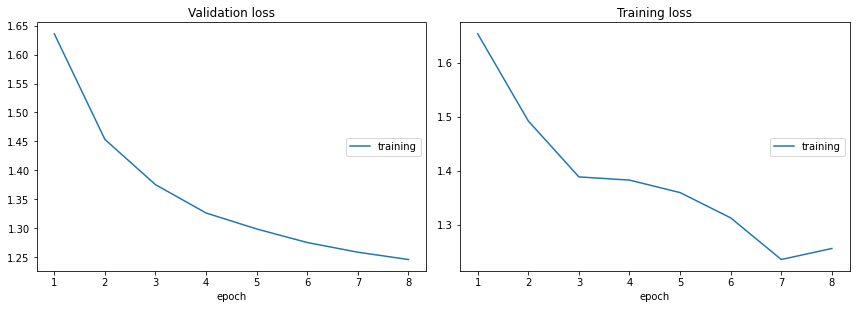

Validation loss:
training   (min:    1.246, max:    1.636, cur:    1.246)

Training loss:
training   (min:    1.235, max:    1.653, cur:    1.256)
Example of a text generated by current model:
I said you don't know  
Baby don't you go  
  
Oh the coldier  
The way you said to be  
I won't let it love is to me  
  
I got me so feeling  
  
I will be mine  
And I would be an end  
The rain  
I'm so sorry  
  
I'm looking for you  
  
Don't wanna live it all to the truth  
  
So tell me that 


In [ ]:
# We now run the actual training
epochs_number = 8


for epoch_number in range(epochs_number):

    for batch in trainset_loader:
        post_processed_batch_tuple = post_process_sequence_batch(batch)
        input_sequences_batch, output_sequences_batch, sequences_lengths = post_processed_batch_tuple
        output_sequences_batch_var =  output_sequences_batch.contiguous().view(-1).cuda()
        input_sequences_batch_var = input_sequences_batch.cuda()
        
        optimizer.zero_grad()
        logits, _ = rnn(input_sequences_batch_var, sequences_lengths)
        
        train_loss = criterion(logits, output_sequences_batch_var)
        train_loss.backward()
        
        optimizer.step()
    
    val_loss_list = []
    
    with torch.no_grad():
      
      for batch in valset_loader:

        post_processed_batch_tuple = post_process_sequence_batch(batch)
        input_sequences_batch, output_sequences_batch, sequences_lengths = post_processed_batch_tuple
        output_sequences_batch_var =  output_sequences_batch.contiguous().view(-1).cuda()
        input_sequences_batch_var = input_sequences_batch.cuda()
        
        logits, _ = rnn(input_sequences_batch_var, sequences_lengths)
        loss = criterion(logits, output_sequences_batch_var)
        
        val_loss_list.append(loss.item())
      
    liveloss.update({'Validation loss': sum(val_loss_list) / len(val_loss_list),
                     'Training loss': train_loss.item()})
    liveloss.draw()
    
    print('Example of a text generated by current model:')
    print(sample_from_rnn(starting_string='I', temperature=0.5))

#### Text Generation

During the text generation process we can define a starting prefix of characters that our model will condition on and generate the rest of the sequence. 

The model generates each new token (characters in our case) by sampling from the output probability distribution. When sampling, we can set a `temperature` parameter that controls the randomness of the sampling process. When this parameter approaches zero, the sampling is equivalent to argmax and when it is close to infinity the sampling is equivalent to sampling from a uniform distribution.

Complete the following `sample_from_rnn` function, using the hints provided in the comments. _(10 points)_

In [ ]:
def sample_from_rnn(starting_string="Why", sample_length=300, temperature=1):
    assert temperature >= 0.0
    sampled_string = starting_string
    hidden = None

    # Prepare the first input to the RNN
    first_input = torch.LongTensor( string_to_labels(starting_string) ).cuda()
    first_input = first_input.unsqueeze(1)
    current_input = first_input

    # Now run the RNN model using current_input as first input. 
    # Note: You may need to look at the Pytorch RNN documentation to
    # understand what it outputs. Hint: It outputs a tuple. 
    
    # YOUR CODE HERE
    output, hidden = rnn(current_input, [len(sampled_string)], hidden=hidden)
    output = output[-1, :].unsqueeze(0)

    # The output of the RNN for each time-step are actually logits 
    # (to be fed into a softmax to get a distribution). To further
    # add randomness to the logits, we will use the temperature parameter.
    # Scale the logits (output of RNN above) by dividing by the temperature
    # (+ 1e-4 so that it is not zero), and then obtain a distribution by
    # feeding this into nn.functional.softmax. Then use torch.multinomial
    # to sample 1 character from this distribution.
    
    for i in range(sample_length):

        output_dist = nn.functional.softmax( output.view(-1).div(temperature + 1e-4) ).data
        predicted_label = torch.multinomial(output_dist, 1) #you code here
        sampled_string += all_characters[int(predicted_label[0])] #you code here
        current_input = predicted_label.unsqueeze(1)
        output, hidden = rnn(current_input, [1], hidden=hidden)
    
    return sampled_string

In [ ]:
print(sample_from_rnn(starting_string='I', temperature=0.5))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


I, I'm alright  
I wanna be will never let me play off the story  
And we wanna live to help me  
Cause I can't take you the sky  
This is the same man  
  
I'm the song  
  
I'm so say  
It's wearing my love is a sinner  
And we touch me and some real to be so good  
When he said to be  
But sometim


__Question:__ How do you obtain probability distribution over the possible characters? _(2 points)_

__Answer:__ We can obtain the probability distribution by dividing logit by temperature, and then use the softmax function.

__Question:__ How does the `temperature` affect the generated text? Describe using some values of temperature. _(3 points)_

__Answer:__ Low temperature values(such as 0.2) result in extremely repetitive and predictable text, but with a very realistic local structure. As temperature rises, the generated text becomes richer, and it sometimes invents new words that sound somewhat reasonable. At high temperatures(suach as 2.0), the local structure starts to break down and most words look like semi-random strings.

__Question:__ Explain why the sequential nature of recurrent neural networks makes them less efficient compared to methods based on convolutions, for example. _(2 points)_

__Answer:__ The sequence-dependent structure of RNN always occurs the problem of vanishing gradient. RNN training applies the same BP algorithm of loss computation backpropagation as CNN training. The difference is that the parameters U, V, and W are shared in RNN, and in the stochastic gradient descent algorithm, the output of each step depends not only on the network of the current step, but also on the network of the time step before the current step. In CNN, the parameters W1 , W2, and W3 of each layer are independent of each other, and W1 , W2W3 perform concatenated multiplication. On the one hand, they are all sparse matrices, and on the other hand, W1 , W2 , and W3 are different from each other, which largely cancel out the effect of gradient explosion. So CNN is more efficient than RNN.


__Question:__ In the homework exercise we have loaded whole text sequences into the GPU memory. Imagine that we will work with sequences of much greater length, how that will this affect GPU memory consumption? How can you solve this problem? _(3 points)_

__Answer:__ The computational complexity of forward propagation of Recurrent neural network is O(|Sequence Length|). The longer the Sequence is, the more computation is required. And each time step in a long Sequence includes a memory I/O operation. This is very slow and is bounded by the maximum threads and maximum memory bandwidth of the GPU.
How to solve: 1.truncated backpropagation through time 2.Use CPU memory to cache activation vectors 3. Parallelize RNN models


__Extra credit:__ In the above class, we used a vanilla RNN. Replace the RNN layers with LSTM or GRU and perform training on the same data. Does it converge faster/slower than the RNN? Try sampling from this model with the same starting string and temperature. Do you observe any difference? _(10 points)_



In [ ]:
# Your code here

#### Implementing a conditional RNNLM

So far our RNN has been trained on lyrics from all the songs without knowledge of artists. Next, we will condition our training by providing the LM with artist information as well.

Below we provide updated functions and dataset class that can be used to train language model that is conditioned on the artist. Complete the functions to implement this conditioned LM. _(10 points)_

In [ ]:
class LyricsGenerationDatasetConditional(data.Dataset):
    
    def __init__(self, csv_file_path, minimum_song_count=None, artists=None):
        
        self.lyrics_dataframe = pd.read_csv(csv_file_path)
        
        if artists:
            self.lyrics_dataframe = self.lyrics_dataframe[self.lyrics_dataframe.artist.isin(artists)]
            self.lyrics_dataframe = self.lyrics_dataframe.reset_index()
        
        if minimum_song_count:
            # Getting artists that have 70+ songs
            self.lyrics_dataframe = self.lyrics_dataframe.groupby('artist').filter(lambda x: len(x) > minimum_song_count)
            # Reindex .loc after we fetched random songs
            self.lyrics_dataframe = self.lyrics_dataframe.reset_index()
        
        # Get the length of the biggest lyric text
        # We will need that for padding
        self.max_text_len = self.lyrics_dataframe.text.str.len().max()
        whole_dataset_len = len(self.lyrics_dataframe)
        self.indexes = range(whole_dataset_len)
        
        # Let's get unique artists and form a list
        self.artists_list = list(self.lyrics_dataframe.artist.unique())

        # We will need the overall number of artists for 
        self.number_of_artists = len(self.artists_list)
    
    def __len__(self):
        return len(self.indexes)
    
    def __getitem__(self, index):
        
        index = self.indexes[index]
        sequence_raw_string = self.lyrics_dataframe.loc[index].text
        sequence_string_labels = string_to_labels(sequence_raw_string)
        sequence_length = len(sequence_string_labels) - 1
        
        # Generate input and output sequence (shifted by 1 character)
        # from the sequence_string_labels
        
        # YOUR CODE (SAME AS EARLIER)
        input_sequence = sequence_string_labels[:-1]
        output_sequence = sequence_string_labels[1:]        

        # Pad sequences so that all of them have the same length. For
        # the output sequence, use pad_label=-100 so that it is omitted
        # in cross-entropy loss. 

        # YOUR CODE (SAME AS EARLIER)
        input_string_labels_padded = pad_sequence(input_sequence,self.max_text_len) 
        output_string_labels_padded = pad_sequence(output_sequence,self.max_text_len,pad_label=-100)

        # For the given index argument, obtain the artist name from self.lyrics_dataframe
        # and then get the corresponding index from self.artists_list. Store this
        # value as sequence_artist_label
        
        # YOUR CODE HERE
        artist_name = self.lyrics_dataframe.loc[index].artist
        sequence_artist_label = self.artists_list.index(artist_name)

        return (torch.LongTensor(input_string_labels_padded),
                torch.LongTensor(output_string_labels_padded),
                torch.LongTensor([sequence_artist_label]),
                torch.LongTensor([sequence_length]) )


# This function can be skipped
def post_process_sequence_batch_conditional(batch_tuple):
    
    input_sequences, output_sequences, artists, lengths = batch_tuple
    
    splitted_input_sequence_batch = input_sequences.split(split_size=1)
    splitted_output_sequence_batch = output_sequences.split(split_size=1)
    splitted_artists_batch = artists.split(split_size=1)
    splitted_lengths_batch = lengths.split(split_size=1)

    training_data_tuples = zip(splitted_input_sequence_batch,
                               splitted_output_sequence_batch,
                               splitted_artists_batch,
                               splitted_lengths_batch)

    training_data_tuples_sorted = sorted(training_data_tuples,
                                         key=lambda p: int(p[3]),
                                         reverse=True)

    splitted_input_sequence_batch, splitted_output_sequence_batch, splitted_artists_batch, splitted_lengths_batch = zip(*training_data_tuples_sorted)

    input_sequence_batch_sorted = torch.cat(splitted_input_sequence_batch)
    output_sequence_batch_sorted = torch.cat(splitted_output_sequence_batch)
    artists_batch_sorted = torch.cat(splitted_artists_batch)
    lengths_batch_sorted = torch.cat(splitted_lengths_batch)
    
    
    # Here we trim overall data matrix using the size of the longest sequence
    input_sequence_batch_sorted = input_sequence_batch_sorted[:, :lengths_batch_sorted[0, 0]]
    output_sequence_batch_sorted = output_sequence_batch_sorted[:, :lengths_batch_sorted[0, 0]]
    
    # We should probably repeat this over the whole input sequence
    artists_batch_sorted = artists_batch_sorted.expand_as(input_sequence_batch_sorted)

    input_sequence_batch_transposed = input_sequence_batch_sorted.transpose(0, 1)
    artists_batch_sorted_transposed = artists_batch_sorted.transpose(0, 1)
    
    # pytorch's api for rnns wants lenghts to be list of ints
    lengths_batch_sorted_list = list(lengths_batch_sorted)
    lengths_batch_sorted_list = list(map(lambda x: int(x), lengths_batch_sorted_list))
    
    return input_sequence_batch_transposed, output_sequence_batch_sorted, artists_batch_sorted_transposed, lengths_batch_sorted_list


class RNN_Conditional(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_classes, num_conditions, n_layers=2):
        
        super(RNN_Conditional, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.n_layers = n_layers
        self.num_conditions = num_conditions
        
        # Converts labels into one-hot encoding and runs a linear
        # layer on each of the converted one-hot encoded elements
        
        # input_size -- size of the dictionary + 1 (accounts for padding constant)
        `
        
        
        `
        
        self.characters_embedder = nn.Embedding(self.input_size,self.hidden_size,100) # YOUR CODE HERE
        self.artist_embedder = nn.Embedding(self.num_conditions,self.hidden_size) # YOUR CODE HERE
        self.rnn = nn.RNN(self.hidden_size*2,self.hidden_size,self.n_layers) # YOUR CODE HERE
        self.logits_fc = nn.Linear(self.hidden_size,self.num_classes) # YOUR CODE HERE
    
    
    def forward(self, input_sequences, input_sequences_conditions, input_sequences_lengths, hidden=None):
        
        batch_size = input_sequences.shape[1]

        characters_embedded = self.characters_embedder(input_sequences)
        conditions_embedded = self.artist_embedder(input_sequences_conditions)
        
        embedded_combined = torch.cat((characters_embedded, conditions_embedded), dim=2)

        # Here we run rnns only on non-padded regions of the batch
        packed = torch.nn.utils.rnn.pack_padded_sequence(embedded_combined, input_sequences_lengths)
        outputs, hidden = self.rnn(packed, hidden)
        outputs, output_lengths = torch.nn.utils.rnn.pad_packed_sequence(outputs) # unpack (back to padded)
        
        logits = self.logits_fc(outputs)
        logits = logits.transpose(0, 1).contiguous()
        logits_flatten = logits.view(-1, self.num_classes)
        
        return logits_flatten, hidden

#### Training the conditional LM

In [ ]:
trainset = LyricsGenerationDatasetConditional(csv_file_path='songdata.csv', artists=artists)

trainset_loader = torch.utils.data.DataLoader(trainset,
                                              batch_size=50,
                                              shuffle=True, num_workers=4, drop_last=True)

In [ ]:
rnn = RNN_Conditional(input_size=len(all_characters) + 1,
          hidden_size=512,
          num_classes=len(all_characters),
          num_conditions=trainset.number_of_artists)

rnn.cuda()

learning_rate = 0.001
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss().cuda()

In [ ]:
from livelossplot import PlotLosses

liveloss_train = PlotLosses()
liveloss_val = PlotLosses()

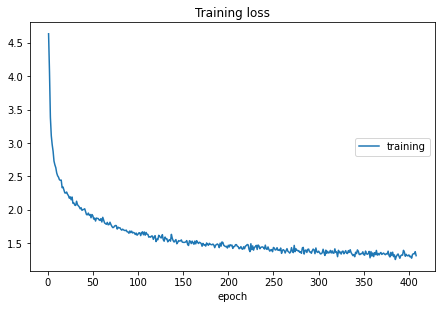

Training loss:
training   (min:    1.254, max:    4.635, cur:    1.312)


KeyboardInterrupt: ignored

In [22]:
# Conditional model takes more to converge,
# Try training for more epochs for better results
epochs_number = 500

for epoch_number in range(epochs_number):

    for batch in trainset_loader:

        post_processed_batch_tuple = post_process_sequence_batch_conditional(batch)
        input_sequences_batch, output_sequences_batch, artists_batch, sequences_lengths = post_processed_batch_tuple
        output_sequences_batch_var = output_sequences_batch.contiguous().view(-1).cuda()
        
        input_sequences_batch_var = input_sequences_batch.cuda()
        artists_batch_var = artists_batch.cuda()
        
        optimizer.zero_grad()

        logits, _ = rnn(input_sequences_batch_var,  `` artists_batch_var, sequences_lengths)
        
        loss = criterion(logits, output_sequences_batch_var)
        loss.backward()
        
    liveloss_train.update({'Training loss': loss.item()})
    liveloss_train.draw()

    #torch.nn.utils.clip_grad_norm(rnn.parameters(), clip)

    optimizer.step()
        
    torch.save(rnn.state_dict(), 'conditional_rnn.pth')

__Note: After 5 hours' exceuting, the colab said "Busy" and cannot proceed to more epoches, so I interrupted at this time.__

#### Generating from the conditional LM

__Question:__ Implement a function `sample_from_rnn_conditionally(artist_label, starting_string, temperature)` similar to the `sample_from_rnn()` function shown earlier. Use this function to generate an Eminem song starting with "Why". _(10 points)_

In [25]:
# YOUR CODE HERE

def sample_from_rnn_conditionally(artist_label,starting_string="Why", temperature=1):
    assert temperature >= 0.0
    sampled_string = starting_string
    hidden = None

    # Prepare the first input to the RNN
    first_input = torch.LongTensor(string_to_labels(starting_string)).cuda()
    first_input = first_input.unsqueeze(1)

    # Prepare the second input to the RNN
    second_input = torch.LongTensor(string_to_labels(artist_label)).cuda()
    second_input = first_input.unsqueeze(1)

    output, hidden = rnn(first_input, second_input, [len(sampled_string)],hidden = hidden)
    output = output[-1, :].unsqueeze(0)
    
    for i in range(sample_length):

        output_dist = nn.functional.softmax( output.view(-1).div(temperature + 1e-4) ).data
        predicted_label = torch.multinomial(output_dist, 1) #you code here
        sampled_string += all_characters[int(predicted_label[0])] #you code here
        current_input = predicted_label.unsqueeze(1)
        output, hidden = rnn(current_input, [1], hidden=hidden)
    
    return sampled_string


In [ ]:
sample_from_rnn_conditionally('Eminem','Why',temperature = 0.5 )

Why do you say I have something but you can see you  
I won't let you all we all go  
  
Cause you're our life with me  
  
I wanna stand what you know you're gonna rain to be  
  
I'm a little more  
I want to call me to spend it and me  
  
I'm so slipped to be with you  
And say what you can't be th


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


__Answer:__ lyrics as above.

### Part 2: Distributional Semantics: The Word2Vec model

In Part 2 of this assignment, you will use Word2Vec to analyze some of interesting phenomena that arises from distributional semantics. For this, we will use a pretrained model from the [Gensim](https://radimrehurek.com/gensim/) package.


Before we dive into this analysis, first read a little bit of theory about the Word2Vec model and answer a few questions below.

#### Understanding word2vec

The basic architecture of the skip-gram model is shown below (taken from [this post](https://israelg99.github.io/2017-03-23-Word2Vec-Explained/)):

![](https://israelg99.github.io/images/2017-03-23-Word2Vec-Explained/skip_gram_net_arch.png)

In this model, word embeddings are trained using a classification task, where the task is that given a word, you have to predict its context words (i.e. words which occur before and after it in a context of size, say, 2). The objective is to learn the probability of any word $O$ given a center word $C$, i.e. $P(O=o \mid C=c)$.

In this model, this probability is computed by taking the vector dot product of the embeddings for $o$ and $c$, and then applying a softmax (to convert it into a probability distribution):

$$
P(O=o \mid C=c)=\frac{\exp \left(\boldsymbol{v}_{o}^{\top} \boldsymbol{v}_{c}\right)}{\sum_{w \in \operatorname{Vocab}} \exp \left(\boldsymbol{v}_{w}^{\top} \boldsymbol{v}_{c}\right)}
$$

The vectors $\boldsymbol{v}_{w}$ are initialized randomly for all the words in the vocabulary and then updated during training. The objective, in fact, tries to maximize the above probability of words in context occuring together. Stating it different, it miniimized the negative log-probability, i.e.,

$$ J = -\log P(O=o \mid C=c). $$

Here is another interpretation of this objective function. Suppose ${y}$ and $\hat{y}$ are vectors of length $|V|$ (size of vocabulary), and the index $k$ in each of these denotes the conditional probability of word $k$ being in the context of given word $c$. $y$ is the empirical distribution (ground truth), i.e., it is a one-hot vector, whereas $\hat{y}$ is the predicted distribution. In our case, we would have $P(O=o \mid C=c) = \hat{y}_o$. Then the loss function $J$ above is equivalent to the binary cross-entropy loss between $y$ and $\hat{y}$.

__Question:__ The cross-entropy loss between 2 distributions is given as $-\sum_i p_i \log q_i$. With this information, show that the cross-entropy between $y$ and $\hat{y}$ is equal to $-\log \hat{y}_o$. _(5 points)_

__Answer:__ Because the true distribution $y$ is a one-hot vector, i.e., the value is 1 only at the current position of the true contextual word $O$. Therefore:

$$-\sum_{w\in Vocab} y_w \log \hat y_w = - 1 \times \log \hat y_o = - \log P(O = o | C = c)$$

Note that in the softmax computation, the denominator computes a sum over the entire vocabulary. This is very computationally expensive. In the actual word2vec implementation, we use something called Negative Sampling instead of computing the softmax this way:

$$J^{\prime} = -\log \sigma(v_o v_c) - \sum_{k=1}^K \log \sigma(-v_k v_c)$$

Here, $v_k$ is the embedding for a word which is not present in the context. Intuitively, this loss function pushes $v_c$ closer to its context word $v_o$ while pulling it away from randomly sampled $K$ non-context (or negative) words, hence the name negative sampling.

An important component of the above objective is the sigmoid function $\sigma(x) = \frac{e^x}{e^x + 1}$.

__Question:__ Compute the derivative of $\sigma(x)$ w.r.t $x$. Write the derivative in terms of $\sigma(x)$. (Show the derivation steps.) _(5 points)_ 


__Answer:__  First, we get the the derivative of sigmoid function $\sigma(x)$,  which is : $$\frac{\partial \sigma(x)}{\partial x} = \frac{e^{-x}}{(1+e^{-x})} = \sigma (x) (1-\sigma (x))$$.

Then, we compute the derivative of $v_c$ in terms of $\sigma(x)$:

$$\frac {\partial J'}{\partial v_c} = -(1-\sigma(u_{o}^Tv_c))u_o + \sum_{k=1}^K(1-\sigma(-u_{k}^Tv_c))u_k$$

the derivative of $u_k$ in terms of $\sigma(x)$:

$$\frac {\partial J'}{\partial u_k} = -(1-\sigma(u_{o}^Tv_c))v_c$$

$\sigma(x)$ has the nice property that its derivative can be represented using it directly. This makes it useful for gradient-based optimization. In the following, we will use the `gensim` implementation of Word2Vec, which means you don't need to implement any of the training yourself, but it is important to understand what goes on under the hood.

#### Using word2vec

In this section, we will use the GenSim implementation of Word2Vec for some exploration. First, let us train a Word2Vec model on our corpus.


In [26]:
def load_embedding_model():
  """ Load GloVe Vectors
      Return:
          wv_from_bin: All 400000 embeddings, each lengh 200
  """
  import gensim.downloader as api
  wv_from_bin = api.load("glove-wiki-gigaword-200")
  print("Loaded vocab size %i" % len(wv_from_bin.vocab.keys()))
  return wv_from_bin

In [27]:
# -----------------------------------
# Run Cell to Load Word Vectors
# Note: This will take several minutes
# -----------------------------------
wv_from_bin = load_embedding_model()
print(wv_from_bin)

[==================================================] 100.0% 252.1/252.1MB downloaded
Loaded vocab size 400000


In [28]:
# access vector for one word
print(wv_from_bin['man'])

[ 1.0627e-01 -5.8248e-01 -2.7217e-01 -2.6772e-01 -1.1844e-01 -1.3373e-03
 -1.8707e-01  1.5110e-01  2.0336e-01 -5.0561e-01 -5.6029e-02 -1.4278e-01
  2.7876e-01  5.6570e-01  1.0539e-01  2.0012e-01 -1.0245e-01  3.8694e-01
  4.9881e-03 -2.0792e-01  4.3314e-01  2.7799e+00 -3.7724e-03 -1.5376e-01
  3.5440e-03 -3.2788e-01 -2.2937e-01 -3.2938e-01  1.0435e-01  1.8370e-01
 -2.0869e-01 -1.2898e-01  1.9762e-01  5.7719e-01  4.8807e-01 -2.2012e-01
 -7.8150e-01 -2.6464e-01 -4.6928e-01  4.8230e-01 -7.2708e-01  1.7301e-02
 -3.5347e-01  1.6986e-01 -4.0509e-01  3.1622e-02 -8.5332e-02  1.1077e-01
  2.3554e-01 -1.8391e-01  2.3047e-01  5.0146e-01  1.8733e-01  3.3038e-01
  3.8698e-01 -1.6126e-01 -1.2255e-01 -6.4396e-02  5.2114e-01 -1.9056e-01
 -2.9464e-01 -2.8260e-01 -8.4987e-01  2.0800e-01 -4.2650e-02 -3.0999e-01
  4.5363e-01  3.4151e-01 -6.6935e-03  6.2788e-02  4.3688e-02 -3.1161e-01
 -1.7607e-01  6.5094e-01 -5.8473e-01 -3.6569e-01 -3.4423e-01 -4.3389e-01
  6.5343e-02 -1.2442e-01  1.7572e-01 -2.8400e-01  1

__Embedding analysis:__ Choose 20 words at random from the lexicon and obtain their corresponding embeddings. Reduce the embedding dimensionality to 2 (using PCA or T-SNE) and plot them. Do you observe any clusters forming? _(10 points)_



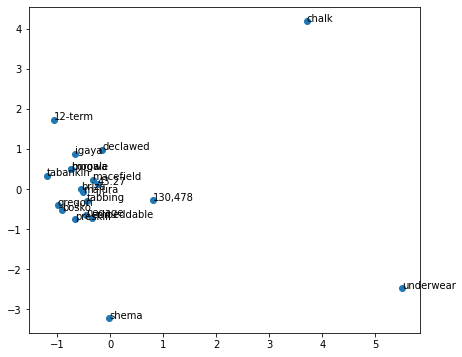

In [29]:
# Your code here
import random
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
random_words = random.sample(list(wv_from_bin.vocab.keys()),20)
embedding_list = []
for word in random_words:
  embedding_list.append(wv_from_bin[word])

pca = PCA(n_components=2)
result = pca.fit_transform(embedding_list)
# 可视化展示
plt.figure(figsize=(7,6)) 
plt.scatter(result[:, 0], result[:, 1])
words = list(random_words)
for i, word in enumerate(words):
	plt.annotate(word, xy=(result[i, 0], result[i, 1]))
plt.show()



__Answer:__ Yes, obvious clusters on the figure can easily be observed.

__Synonyms and antonyms:__ Find three words (w1,w2,w3) where w1 and w2 are synonyms and w1 and w3 are antonyms, but Cosine Distance(w1,w3) < Cosine Distance(w1,w2). For example, w1="happy" is closer to w3="sad" than to w2="cheerful".

Once you have found your example, please give a possible explanation for why this counter-intuitive result may have happened.

You should use the the `wv_from_bin.distance(w1, w2)` function here in order to compute the cosine distance between two words. _(5 points)_

In [30]:
# Your code here
import math
def find_pairs(compare_word,syn,ant):
  for word1,prob1 in syn:
    dist1 = math.cos(wv_from_bin.distance(compare_word,word1))
    for word2,prob2 in ant:
      dist2 =  math.cos(wv_from_bin.distance(compare_word,word2))
      if dist1 > dist2:
        return word1,word2
'''vocab = list(wv_from_bin.vocab)
for compare_word in vocab[:100]:
  syn = wv_from_bin.most_similar(positive=compare_word,topn=200)
  ant = wv_from_bin.most_similar(negative=compare_word,topn=200)
  w= find_pairs(compare_word,syn,ant)
  if w:
    print(compare_word,w[0],w[1])'''
compare_word = 'nice'
syn = wv_from_bin.most_similar(positive=compare_word,topn=100)
ant = wv_from_bin.most_similar(negative=compare_word,topn=100)
w= find_pairs(compare_word,syn,ant)
print(compare_word,w[0],w[1])


nice good m.sambucetti


__Finding analogies:__ Implement a function `analogy()` which solves the analogy problem, e.g., `man:king::woman:x`. Use the `most_similar()` function provided in Gensim for your implementation. _(5 points)_ 

In [31]:
def analogy(x1, x2, y1):
  """Solves for x1:x2::y1:?"""
  # YOUR CODE HERE
  return wv_from_bin.most_similar(positive=[y1, x2], negative=[x1],topn = 1)


Use your `analogy()` function to check if the analogy `man:king::woman:queen` holds for the trained model. Find another such analogy which makes semantic sense. _(5 points)_

In [32]:
# YOUR CODE HERE

a1 = analogy('man','king','woman')
print('man',':','king','::','woman',':',a1[0][0])

a2 = analogy('man', 'woman','father')
print('man',':','woman','::','father',':',a2[0][0])

man : king :: woman : queen
man : woman :: father : mother


__Answer:__ This model can esaily find the answer of the analogy. Another analogy: man:woman::father:mother

__Analyzing bias:__ Complete the following analogies: `man:worker::woman:x` and `woman:worker::man:x` and list the most likely outputs in both cases. Point out the difference between the list of female-associated words and the list of male-associated words, and explain how it is reflecting gender bias. _(5 points)_

In [33]:
# YOUR CODE HERE
# YOUR CODE HERE
a3 = analogy('man', 'worker','woman')
print('man',':','worker','::','woman',':',a3[0][0])

a4 = analogy('woman', 'worker','man')
print('woman',':','worker','::','man',':',a4[0][0])

a5 = analogy('father', 'doctor','mother')
print('father',':','doctor','::','monther',':',a5[0][0])

a6 = analogy('he', 'guitarist','she')
print('he',':','guitarist','::','she',':',a6[0][0])



man : worker :: woman : employee
woman : worker :: man : workers
father : doctor :: monther : nurse
he : guitarist :: she : vocalist


__Answer:__ Due to these two answers for analogies: man:worker::woman:x and woman:worker::man:x, they are obviously different. When it comes to male:female pairs, the answer is like “man is to worker as woman is to x” with x=employee. There are also many different cases such as doctor - nurse and guitarist - vocalist. In additon, words such as "beautiful" and "dance" are also associated with women, while words such as "outstanding" and "genius" are more associated with men. " However, the attributes of these words should have been gender neutral, which reflects the gender bias.

__Question:__ Suggest some ways to deal with the gender (or racial) bias when training word embedding models, or when using pre-trained models. _(5 points)_

__Answer:__ (1) Ensure that gender neutral words such as nurse are equidistant between gender pairs such as he and she.


(2) Reduce gender associations that pervade the embedding even among gender neutral words.